# Particle simulation vs Langevin model

In [1]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

In [2]:
using Plots
# plotly()
gr()

Plots.GRBackend()

## Fixed Density

First we compare the particle simulation with the simulations of the Langevin equation (and some analytical results from it) for a fixed population size.

### Parameters for simulation

In [3]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

extendParams! (generic function with 1 method)

In [63]:
arenaParams = 
    Dict(
        "n0"=>1600,
        "evolveTime"=> 2000,
        "bounds"=>((0.,40.),(0.,40.)), 
        "radius"=>0.08, 
        "speed"=>0.03
    )

extendParams!(arenaParams)
for p in arenaParams
    println(p)
end

Pair{String,Any}("volume", 1600.0)
Pair{String,Any}("evolveTime", 2000)
Pair{String,Any}("speed", 0.03)
Pair{String,Any}("radius", 0.08)
Pair{String,Any}("bounds", ((0.0, 40.0), (0.0, 40.0)))
Pair{String,Any}("bperiod", [40.0, 40.0])
Pair{String,Any}("n0", 1600)


In [64]:
thermVals = Theorist.thermalValues(arenaParams)

Dict{Any,Any} with 6 entries:
  "γ"  => 0.0135765
  "σc" => 0.32
  "D"  => 7.77873e-6
  "l"  => 2.20971
  "E"  => 0.000572958
  "n"  => 1.0

### Simulations

run a particle simulation:

In [65]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = 
    BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams);

println("energy per cell: ",
        BParts.kineticEnergy(arena) / arenaParams["n0"]
    )

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


energy per cell: 0.0005761237757985017


Run an ensemble of Langevin equations:

In [66]:
langevinEnsemble = Theorist.runLangevinSims(1000, arenaParams);

### Analysis

Speed distributions:

For a well mixed population the particle speeds are predicted to be Rayleigh distributed with shape parameter $\sigma = \sqrt{E}$ where $E$ is the average particle energie.

In [76]:
evolveTime = arenaParams["evolveTime"]
speedPar_t_id = BParts.speedCalc(vel_t_dim_id)
speedLan_t_id = Theorist.speedCalc(langevinEnsemble, 1:evolveTime)
rDistPred = Rayleigh( sqrt(thermVals["E"]) );

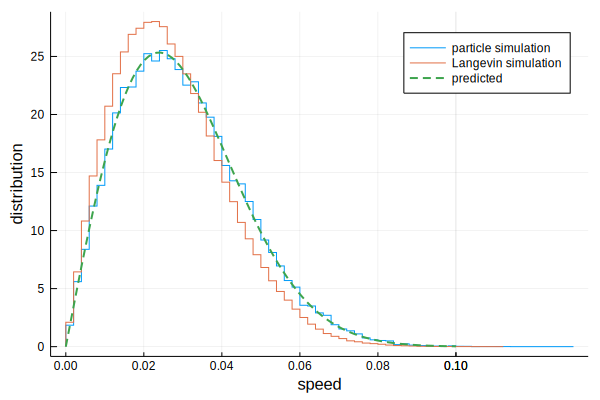

In [77]:
p1 =
histogram(vec(speedPar_t_id), bins=100, normalize=true, label="particle simulation")
histogram!(vec(speedLan_t_id), bins=100, normalize=true, label="Langevin simulation")
plot!(range(0,0.10, length=100), pdf.(rDistPred, range(0,0.10, length=100)), linestyle=:dash, linewidth=2, label="predicted")
xlabel!("speed")
ylabel!("distribution")
display(p1)


While the particle simulation agrees nicely with the predicted Rayleigh distribution, the Langevin simulations appear to deviate slightly. I haven't quite figured out what is causing this. Especially since technically the predicted rayleigh is derived from the Langevin equation...

Velocity Autocorrelation:

In [71]:
corrTime = 200
timesCorr_t, vCorrLan_t = Theorist.velCorrelation(langevinEnsemble, (1,corrTime), steps=corrTime);
vCorrPar_t = BParts.velocityAutocorrelation(vel_t_dim_id[1:corrTime, :, :]);
vCorrPred_t = map( t->2*thermVals["E"]*exp(-thermVals["γ"]*t), 0:corrTime-1 );

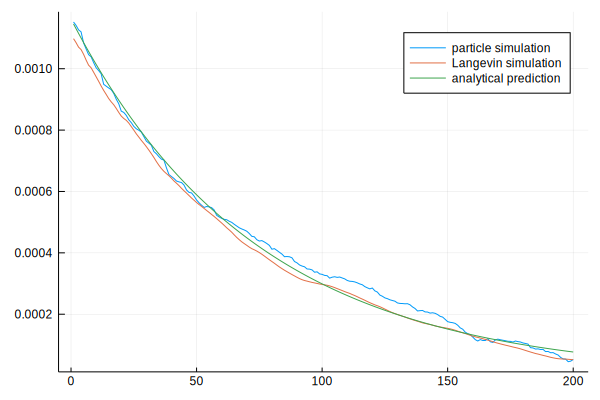

In [72]:
p2 = plot(timesCorr_t, vCorrPar_t, label="particle simulation")
plot!(timesCorr_t, vCorrLan_t, label="Langevin simulation")
plot!(timesCorr_t, vCorrPred_t, label="analytical prediction")
display(p2)

Mean squared displacement:

In [73]:
msdTime = 400
timesMSD_t, msdLan_t = Theorist.msd(langevinEnsemble, arenaParams,  (0, msdTime-1), msdTime);
msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

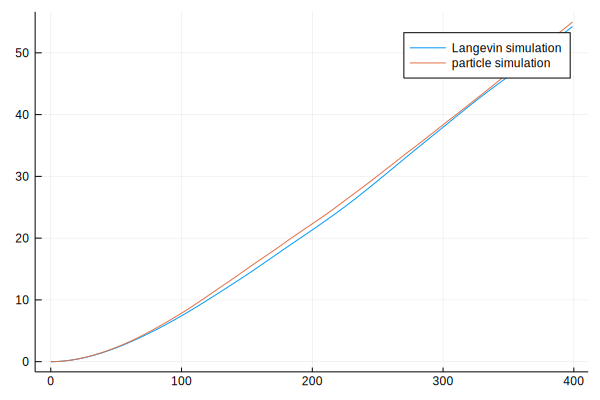

In [74]:
p2 = plot(timesMSD_t, msdLan_t, label="Langevin simulation")
plot!(timesMSD_t, msdPar_t, label="particle simulation")
display(p2)

The msd becomes sublinear after a particular distance due to the periodic boundaries. The effect can be removed by increasing the arena size.